In [1]:
import networkx as nx
import numpy as np
import copy
import random
import time
import itertools

#Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#systems
from ANCR import *
from fluids import *


Make systems
---------
1. Guided random walks
2. Store on each logical edge, network with the following on each edges
    1. Resistance
    2. Current
    3. Pheromones
    4. Heuristics
3. Create instance
    1. Walk for all logical edges based on stored networks
4. Evaluate instance
5. Update edges

Logical Architecture
----------------
1. Define components
2. Define systems
3. Define Edges and populate with components
4. Put physical architecture on each node
    1. each edge of physical architecture has:
        1. Resistance
        2. Current
        3. Pheromones
        4.Heuristics

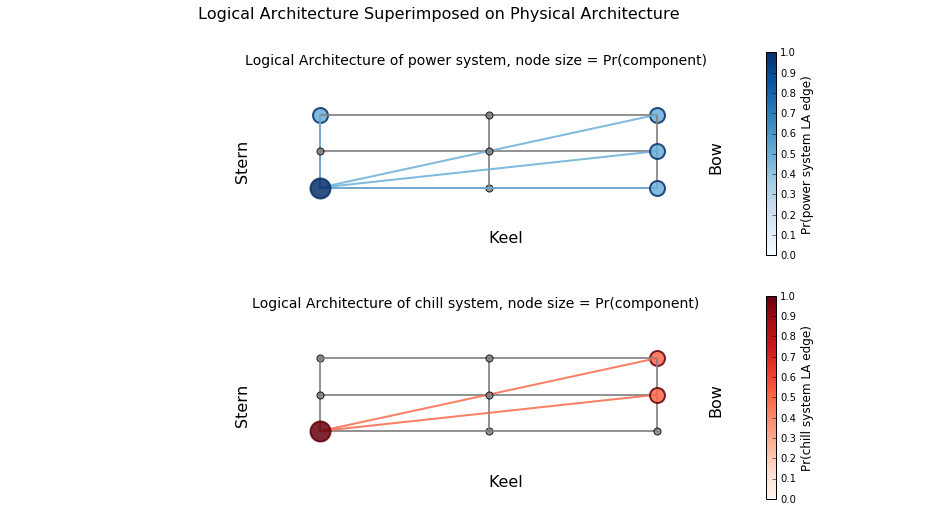

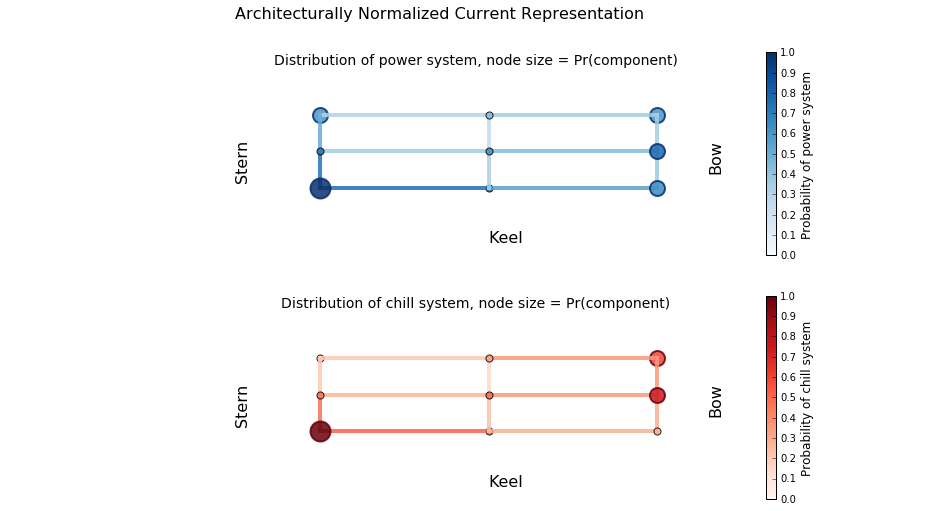

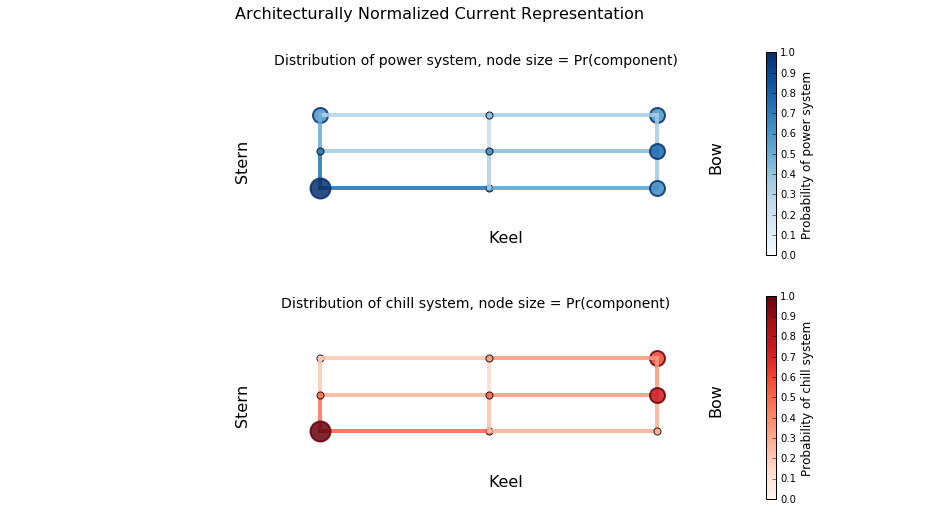

In [20]:
g, la, g_i, ir_la=basic_arch(plot=True)
# print ir_la['components']
# print la['power']['c1']['c2']['g'].edges(data=True)
# print la['power']['c1']['c2']['g'].nodes(data=True)
# ir_la=i_ANCR(g,la)
# g_i=project_current_distribution_bus(g,ir_la,bus={})
# plot_current(g_i,ir_la,scale=.5,elev=0,angle=-90,factor=2.0)

#Test System Draw
# draw=system_draw_i(ir_la)
# for sys in draw:
#     for e,w in draw[sys].iteritems():
#         print e
#         print w

#Test resistance update
l=[]
d=[]
s=[]
for i in xrange(100):
    draw,locs=system_draw_i(ir_la)
    l.append(locs)
    d.append(draw)
    s.append(score_length(draw))
# print l
# print d
# print s
upd_la=update_resistance(ir_la,l,d,s,6.0)
iu_la=i_ANCR(g,upd_la)
# print iu_la['components']
g_iu=project_current_distribution_bus(g,iu_la,bus={})
plot_current(g_iu,iu_la,scale=.5,elev=0,angle=-90,factor=2.0)

In [21]:
def update_pheromones(la,location_list,draw_list,score_list,feasibility_threshold):
    """
    Update pheromones in the logical connection edges based on generated systems and their performance
    In: la: logical architecture with current distributions for routings and components
    location_list: list of dicitonaries with component locations for each system draw, [{component:location}]
    draw_list: list of dictionaries with system draws, [{sys:logical edge:walkd}]
    score_list: list of scores for system draws
    feasibility_threshold: performance measures thresholds that systems must be below
    Out: upd_la: logical architecture with updated pheromones
    """
    return
    

In [ ]:
def system_draw_p(la):
    """
    Draw system from current distribution on logical architecture
    In: ir_la=logical architecture with currrent on component locations and routings
    Out: sys_draw=probabilistically drawn system, {sys: {logical edge: walk}}
    """
    #draw system from networks
    #generate objective ratio
    
    #Get component locations for walk
    comp_locs=comp_draw_r(la)
    
    #Get walk for system
    sys_draw={}
    for sys in la['systems']:
        net=la[sys]
        sys_draw[sys]={}
        for i,j,d in net.edges(data=True):
            walk_key=(i,j)
            walk=walk_st_p(la,sys,i,j,comp_locs)
            sys_draw[sys][walk_key]=walk

    return sys_draw,comp_locs

In [ ]:
def comp_draw_i(la):
    """
    Selects component locations based on current distribution
    In: la=component and system data
    Out: comp_locs=component locations, locs={component: location}
    """
    
    comp_locs={}
    for comp in la['components']:
        #get and combine pheromones
        vals=list(la['components'][comp]['i'].values())
        locs=list(la['components'][comp]['i'].keys())
        sum_v=sum(vals)
        if sum_v==0.0:
            probs=[1.0/len(vals) for i in xrange(len(vals))] #transition probabilities are uniform
        else:
            probs=[i/sum_v for i in vals] #transition probabilities based on values
        idx=np.random.choice(len(locs),1,p=probs) #select next location based on transition probabilities
        loc=locs[np.squeeze(idx)]
        comp_locs[comp]=loc
    return comp_locs

In [13]:


def update_resistance(la,location_list,draw_list,score_list,feasibility_threshold):
    """
    Update resitances in the logical connection edges based on generated systems and their performance
    In: la: logical architecture with current distributions for routings and components
    location_list: list of dicitonaries with component locations for each system draw, [{component:location}]
    draw_list: list of dictionaries with system draws, [{sys:logical edge:walkd}]
    score_list: list of scores for system draws
    feasibility_threshold: performance measures thresholds that systems must be below
    Out: upd_la: logical architecture with updated resistances
    """
    #R=~0.0
    epsilon=1E-10 

    #iterate through components to remove bad location
    upd_la=copy.deepcopy(la)
    for comp,comp_d in upd_la['components'].iteritems():
        for location in comp_d['loc']:
    #         print comp,location
            #check if location is used in a walk that meets threshold.
            if comp_d['r'][location]==epsilon:
                continue
            met=False
            for c_locs,score in zip(location_list,score_list):
    #             print c_locs,score
                if isinstance(score,float):
                    below=score<=feasibility_threshold
                if isinstance(score,tuple):
                    below=all(x <= y for x, y in zip(score,feasibility_threshold))
                if (location ==c_locs[comp]) and below:
    #                 print comp,location,score 
                    met=True
                    break
            if met==False: #did not meet threshold
                #set r to zero for that component
                upd_la['components'][comp]['r'][location]=epsilon
    # print upd_la['components']


    #iterate through walks to remove bad edges
    for sys in upd_la['systems']:
        la_net=upd_la[sys]
        for i,j,data in la_net.edges(data=True):
            net=data['g']
            for a,b in net.edges():
                if net[a][b]['r']==epsilon:
                    continue
                met=False
                for draw,score in zip(draw_list,score_list):
                    #print draw
                    #print sys,(i,j)
                    la_edge_walk=draw[sys][(i,j)]
                    if isinstance(score,float):
                        below=score<=feasibility_threshold
                    if isinstance(score,tuple):
                        below=all(x <= y for x, y in zip(score,feasibility_threshold))
                    if ((a,b) in la_edge_walk) and below:
    #                     print (a,b),score
                        met=True
                        break
                if met==False:
                    upd_la[sys][i][j]['g'][a][b]['r']=epsilon
#         print sys,i,j
#         for e1,e2,edata in upd_la[sys][i][j]['g'].edges(data=True):
#             print e1,e2
#             print edata
    return upd_la
                    

In [4]:
def score_length(draw):
    """
    Scores the length of the systems
    In: draw=system, {sys: {logical edge: walk}}
    Out: score=total number of edges in each system
    """
    length=0.0
    for sys in draw:
        sys_edges=set()
        for e in draw[sys]:
            sys_edges.update(draw[sys][e])
        length+=len(sys_edges)
    return length

In [5]:
def system_draw_i(ir_la):
    """
    Draw system from current distribution on logical architecture
    In: ir_la=logical architecture with currrent on component locations and routings
    Out: sys_draw=probabilistically drawn system, {sys: {logical edge: walk}}
    """
    #draw system from networks
    #Get component locations for walk
    comp_locs=comp_draw_i(ir_la)
    
    #Get walk for system
    sys_draw={}
    for sys in la['systems']:
        net=la[sys]
        sys_draw[sys]={}
        for i,j,d in net.edges(data=True):
            walk_key=(i,j)
            walk=walk_st_i(ir_la,sys,i,j,comp_locs)
            sys_draw[sys][walk_key]=walk

    return sys_draw,comp_locs
        

In [6]:
def walk_st_i(la,sys,s,t,comp_locs):
    """
    Creates walk from s to t based on current distribution
    In: la=component and system data, sys=system, 
        s=starting component, t=ending component, 
        comp_loc=map of components to locations
    Out: w=list of edges in walk
    """
    #Get network to walk through
    g=la[sys][s][t]['g'].copy()
    loc=comp_locs[s] #starting location
    end=comp_locs[t] #ending location
    
    w=[]
    while loc!=end: #start walk
        vals=[]
        nodes=g.neighbors(loc)
        edges=[]
#         print nodes
        for n in nodes:
            #e=(loc,n)
#             print (loc,n)
            if (loc,n) in g.edges():
                e=(loc,n)
            else:
                e=(n,loc)
#             print e
            edges.append(e)
            if e not in w: #has not been used in the walk
                vals.append(g[e[0]][e[1]]['i']) #can use that edges
            else: #has been used in walk
                vals.append(0.0) #don't use again

        sum_v=sum(vals)
        if sum_v==0:
            probs=[1.0/len(vals) for i in xrange(len(vals))] #transition probabilities are uniform
        else:
            probs=[i/sum_v for i in vals] #transition probabilities based on i
#         print nodes
#         print probs
        idx=np.random.choice(len(nodes),1,p=probs) #select next location based on transition probabilities
        loc=nodes[np.squeeze(idx)]
        w.append(edges[np.squeeze(idx)])
#         print w,loc
        
    return w

In [7]:
def comp_draw_p(la):
    """
    Selects component locations based on current distribution
    In: la=component and system data
    Out: comp_locs=component locations, locs={component: location}
    """
    comp_locs={}
    for comp in la['components']:
        l_vals=list(la['components'][comp]['ph'].values()) #list of lists
        locs=list(la['components'][comp]['ph'].keys()) #list of locations
        for v in l_vals:
            #Combine pheromones in each list
        sum_v=sum(vals)
        if sum_v==0.0:
            probs=[1.0/len(vals) for i in xrange(len(vals))] #transition probabilities are uniform
        else:
            probs=[i/sum_v for i in vals] #transition probabilities based on values
        idx=np.random.choice(len(locs),1,p=probs) #select next location based on transition probabilities
        loc=locs[np.squeeze(idx)]
        comp_locs[comp]=loc
    return comp_locs

In [8]:
from networkx.algorithms.centrality.flow_matrix import *
from networkx.utils import reverse_cuthill_mckee_ordering

def current_st(G, ss, tt, normalized=False, weight='r', dtype=float, solver='lu'):
    r"""Compute current-flow betweenness centrality for subsets of nodes.

    Current-flow betweenness centrality uses an electrical current
    model for information spreading in contrast to betweenness
    centrality which uses shortest paths.

    Current-flow betweenness centrality is also known as
    random-walk betweenness centrality [2]_.

    Parameters
    """

    try:
        import numpy as np
    except ImportError:
        raise ImportError('current_flow_betweenness_centrality requires NumPy ',
                          'http://scipy.org/')
    try:
        import scipy
    except ImportError:
        raise ImportError('current_flow_betweenness_centrality requires SciPy ',
                          'http://scipy.org/')
    if G.is_directed():
        raise nx.NetworkXError('current_flow_betweenness_centrality() ',
                               'not defined for digraphs.')
    if not nx.is_connected(G):
        raise nx.NetworkXError("Graph not connected.")
    n = G.number_of_nodes()
    ordering = list(reverse_cuthill_mckee_ordering(G))
    # make a copy with integer labels according to rcm ordering
    # this could be done without a copy if we really wanted to
    mapping = dict(zip(ordering, range(n)))
    #     print mapping
    H = nx.relabel_nodes(G, mapping)
    betweenness = dict.fromkeys(H.nodes() + H.edges(), 0.0)  # b[v]=0 for v in H
    for row, (s, t) in flow_matrix_row(H, weight=weight, dtype=dtype,
                                       solver=solver):
        #         print row, (s,t)

        i = mapping[ss]
        j = mapping[tt]
        betweenness[s] += 0.5 * np.abs(row[i] - row[j])
        betweenness[t] += 0.5 * np.abs(row[i] - row[j])
        betweenness[(s, t)] += np.abs(row[i] - row[j])
    if normalized:
        nb = (n - 1.0) * (n - 2.0)  # normalization factor
    else:
        nb = 2.0
    for v in H:
        betweenness[v] = betweenness[v]  # /nb#+1.0/(2-n)
    betweenness[mapping[ss]] = 1.0
    betweenness[mapping[tt]] = 1.0
    I = {}
    for k, v in betweenness.items():
        if k in H.nodes():
            I[ordering[k]] = v
        else:
            e = (ordering[k[0]], ordering[k[1]])
            I[e] = v

            #     return dict((ordering[k],v) for k,v in betweenness.items())
    return I


def i_arrange_g(g, la):
    """
    Allocated comoponents in the logical architecture based on current flow
    In: g=phyiscal arch: network ,la=logical arch: {'sys':la_sys}
    Out: i_la logical architecture with allocated components based on current distribution

    For unallocated components, create super node with edges from possible locations
    if both unallocated - calculate current from super node to super node
    if one allocated - calculate from each allocated location to super node

    """

    p_loc = {}

    # iterate through systems
    for sys, net in la.iteritems():
        if sys not in la['systems']:
            continue
        # update p_loc with components in system
        for n in net.nodes():
            if n not in p_loc:
                # update p_loc with empty locations
                p_loc[n] = {loc: [] for loc in la['components'][n]['loc']}
                #                 p_loc[n]=dict.fromkeys(net.node[n]['loc'].keys(),[])

        # iterate through edges
        for i, j, d in net.edges(data=True):
            # get current distribution for edge
            p, i_loc, j_loc = i_dist_g(g, la, sys, (i, j))
            #print i, i_loc
            #print j, j_loc
            for loc in i_loc:
                #                 print i, loc, i_loc[loc], p_loc[i]
                p_loc[i][loc].append(i_loc[loc])
            # print 'after', p_loc[i]
            for loc in j_loc:
                #                 print j, loc, j_loc[loc],p_loc[j]
                p_loc[j][loc].append(j_loc[loc])
                #                 print 'after', p_loc[j]
                #             p_loc[j].append(j_loc)

                #     print p_loc

    comp_loc = {}
    # get probability of locations
    #print p_loc
    for comp in p_loc:
        comp_loc[comp] = {}
        p_t = 0.0
        for loc in p_loc[comp]:
            p_l = 1.0
            for prob in p_loc[comp][loc]:
                p_l *= prob
            # p_complement=reduce(lambda x, y: (1.0-x)*y, p_loc[comp][loc])
            comp_loc[comp][loc] = p_l
            p_t += p_l
        # print comp, loc, p_l,p_t

        #         print comp_loc

        # normalize
        for loc in p_loc[comp]:
            comp_loc[comp][loc] = comp_loc[comp][loc] / p_t

            #     print comp_loc

    i_la = copy.deepcopy(la)
    #print comp_loc
    
    #update component locations
    for component in i_la['components']:
        i_la['components'][component]['i']=dict(comp_loc[component])
    
    for sys, net in la.iteritems():
        if sys not in la['systems']:
            continue
        # update p_loc with components in system
        for n in net.nodes():
            i_la[sys].node[n]['loc'] = dict(comp_loc[n])

            #     for sys, net in la.iteritems():
            #         print 'original',sys, la[sys].nodes(data=True)
            #         print 'updated',sys, la_i[sys].nodes(data=True)

    return i_la


def i_route_g(g, la):
    """
    Get routings between components based on current flow
    In: g=phyiscal arch: network ,la=logical arch: {'sys':la_sys}
    Out: ir_la logical architecture with routing distributions based on current distribution

    For unallocated components, create super node with edges from possible locations
    if both unallocated - calculate current from super node to super node
    if one allocated - calculate from each allocated location to super node

    """

    ir_la = copy.deepcopy(la)

    # iterate through systems
    for sys, net in la.iteritems():
        if sys not in la['systems']:
            continue
        # iterate through edges
        for i, j, d in net.edges(data=True):
            # get current distribution for edge
            p, i_loc, j_loc = i_dist_g(g, la, sys, (i, j))
            ir_la[sys][i][j]['i'] = dict(p)
            
            #add current to edges on edge network
            for n in ir_la[sys][i][j]['g'].nodes():
                ir_la[sys][i][j]['g'].node[n]['i']=float(p[n])
            for a,b in ir_la[sys][i][j]['g'].edges():
                ir_la[sys][i][j]['g'][a][b]['i']=float(p[(a,b)])
            

    return ir_la


def i_ANCR(g, la):
    """
    Allocates comoponents and routes in the logical architecture based on current flow
    In: g=phyiscal arch: network ,la=logical arch: {'sys':la_sys}
    Out: ir_la logical architecture with allocated components and routings based on current distribution

    For unallocated components, create super node with edges from possible locations
    if both unallocated - calculate current from super node to super node
    if one allocated - calculate from each allocated location to super node

    """
    i_la = i_arrange_g(g, la)

    ir_la = i_route_g(g, i_la)

    return ir_la


def i_dist_g(g, la, sys, e):
    """
    Creates current flow for a single edge in logical architecture with unallocated components
    In: g=phyiscal arch, el=logical edge: (loc_1,loc_2),la=logical arch,sys=system
    Out: p_r=current distribution for that edge, i_loc=distribution of component_i, j_loc=distribution of component_j

    For unallocated components, create super node with edges from possible locations
    if both unallocated - calculate current from super node to super node
    if one allocated - calculate from each allocated location to super node

    """
    #     print 'i={}, j={}'.format(e[0],e[1])

    i_locs_ini = dict(la['components'][e[0]]['loc'])
    j_locs_ini = dict(la['components'][e[1]]['loc'])

    g_super = copy.deepcopy(la[sys][e[0]][e[1]]['g'])
    

    # Check if components are unallocated
    if 'un' in i_locs_ini.values():
        # if unallocated add super node
        i_unal = True
        i_edges=[]
        for x in i_locs_ini.keys():
            g_super.add_edge(x,'i_super',r=float(la['components'][e[0]]['r'][x]))
            i_edges.append((x,'i_super'))
            #if i_locs_ini[x]!=0.0:
                #i_edges.append((x,'i_super'))
                
        # print i_edges
        # i_edges = [(x, 'i_super') for x in i_locs_ini.keys()]
        #g_super.add_edges_from(i_edges)
        i_locs = {'i_super': 1.0}
    else:
        i_unal = False
        i_locs = dict(i_locs_ini)

    if 'un' in j_locs_ini.values():
        # if unallocated add super node
        j_unal = True
        j_edges = []
        for x in j_locs_ini.keys():
            g_super.add_edge(x,'j_super',r=float(la['components'][e[1]]['r'][x]))
            j_edges.append((x, 'j_super'))
            #if j_locs_ini[x] != 0.0:
                #j_edges.append((x, 'j_super'))
        # print j_edges
        # j_edges = [(x, 'j_super') for x in j_locs_ini.keys()]
        #g_super.add_edges_from(j_edges)
        j_locs = {'j_super': 1.0}
    else:
        j_unal = False
        j_locs = dict(j_locs_ini)

    # Get current distribution for locations
    p_r = dict.fromkeys(g_super.nodes() + g_super.edges(), 0.0)  # probability dictionary

    #     print 'i',i_locs
    #     print 'j',j_locs
    #
    for i_loc, belief_i in i_locs.iteritems():
        for j_loc, belief_j in j_locs.iteritems():
            I = current_st(g_super, i_loc, j_loc)
            for ele in p_r:
                #               print i_loc,j_loc,ele

                # check if element is formatted
                if ele in I:
                    # print ele
                    switch = False
                elif ele[::-1] in I:
                    # print 'switch',(ele[1],ele[0])
                    switch = True
                    ele = ele[::-1]

                p_ele = belief_i * belief_j * I[ele]
                #                 print ele,p_ele
                # print p_n
                if not switch:
                    p_r[ele] += p_ele
                elif switch:
                    p_r[ele[::-1]] += p_ele

    # Get allocations
    # print p_r
    if i_unal == True:
        #         i_al={k[0]: p_r[k] for k in i_edges}
        i_al = {}
        for k in i_edges:
            if k in p_r:
                i_al[k[0]] = p_r[k]
            else:
                k_rev = (k[1], k[0])
                i_al[k_rev[1]] = p_r[k_rev]

        #repopulate 0.0 location
        for x in i_locs_ini.keys():
            if i_locs_ini[x] == 0.0:
                i_al[x]=0.0
        # print i_al
    else:
        i_al = i_locs

    if j_unal == True:
        #         j_al={k[0]: p_r[k] for k in j_edges}
        j_al = {}
        for k in j_edges:
            if k in p_r:
                j_al[k[0]] = p_r[k]
            else:
                k_rev = (k[1], k[0])
                j_al[k_rev[1]] = p_r[k_rev]

        # repopulate 0.0 location
        for x in j_locs_ini.keys():
            if j_locs_ini[x] == 0.0:
                j_al[x] = 0.0

        # print j_al
    else:
        j_al = j_locs

    # Get current distribution
    p = {}  # probability dictionary without super nodes
    for k in g.nodes() + g.edges():
        if k in p_r:
            p[k] = p_r[k]
        else:
            k_rev = (k[1], k[0])
            p[k] = p_r[k_rev]

    # p_r={k: p_r[k] for k in g.nodes()+g.edges()}

    return p, i_al, j_al


In [9]:
def project_current_distribution_bus(g, LA_I,bus={}):
    """
    Projects the current distributions on the logical architecture to the physical architecture
    In:
    LA_I = logical architecture with current distribution on edges, {sys:logical network: nodes+edges:prob occupied}
    g = physical architecture
    bus = bus locations for distribution system, {sys:nodes+edges}

    Out:
    g_current = physical architecture network with probability of occupancy,
        g_current[ele]={('sys1'):p_sys1, ('sys2'):p_sys2}
    """
    g_comp = g.copy()  # Track complementary probability P(not sys)

    for sys, l_net in LA_I.iteritems():
        if sys not in LA_I['systems']:
            continue
        # print sys
        # create initial complementary node and edge values
        nx.set_node_attributes(g_comp, sys, 1.0)
        nx.set_edge_attributes(g_comp, sys, 1.0)

        for i, j, d in l_net.edges(data=True):  # get edges within logical architecture
            # d={node,edge: prob occupied}
            #             print i,j,d
            for n in g_comp.nodes():
                g_comp.node[n][sys] *= (1.0 - d['i'][n])

            for ni, nj in g_comp.edges():
                # print (ni,nj), d[(ni,nj)]
                # print g_comp.edge[ni][nj][sys]
                if (ni, nj) not in d['i']:
                    g_comp[ni][nj][sys] *= (1.0 - d['i'][(nj, ni)])  # multiply by compliment
                else:
                    g_comp[ni][nj][sys] *= (1.0 - d['i'][(ni, nj)])  # multiply by compliment

                    # for n,d in g_comp.nodes(data=True):
                    # print n,d

                    # for e1,e2,d in g_comp.edges(data=True):
                    # print (e1,e2),d

    g_current = g_comp.copy()  # Get current flow: 1-Pc

    for sys in LA_I:
        if sys not in LA_I['systems']:
            continue
        if sys in bus:
            sys_bus=bus[sys]
        else:
            sys_bus=nx.Graph()
        for n in g_current.nodes():
            if n in sys_bus.nodes():
                g_current.node[n][sys]=1.0
            else:
                g_current.node[n][sys] = 1.0 - g_comp.node[n][sys]
        for i, j in g_current.edges():
            if ((i,j) in sys_bus.edges()) or ((j,i) in sys_bus.edges()):
                g_current[i][j][sys]=1.0
            else:
                g_current[i][j][sys] = 1.0 - g_comp.edge[i][j][sys]

    """
    for n,d in g_current.nodes(data=True):
        print n,d

    for e1,e2,d in g_current.edges(data=True):
        print (e1,e2),d
    """

    return g_current

In [10]:
def basic_arch(plot=True):
    #Physical Architecture
    g=nx.grid_graph(dim=[3,1,3])

    #Logical Architecture
    la={}
    la['components']={}
    la['systems']=[]
    
    #components
    c1={(0,0,0):1.0}
    la['components']['c1']={}
    la['components']['c1']['loc']=c1
    c2={(2,0,2):.5, (2,0,1):.5}
    la['components']['c2']={}
    la['components']['c2']['loc']=c2
    cu={(2,0,0):'un',(0,0,2):'un'}#,(1,0,0):'un'}
    la['components']['cu']={}
    la['components']['cu']['loc']=cu
    

    #systems
    #power
    p=nx.DiGraph()
    p.add_node('c1',loc=la['components']['c1']['loc'])
    p.add_node('c2',loc=la['components']['c2']['loc'])
    p.add_node('cu',loc=la['components']['cu']['loc'])
    p.add_edges_from([('c1','c2'),('c1','cu')])
    la['power']=p
    la['systems'].append('power')

    #cooling
    c=nx.DiGraph()
    c.add_node('c1',loc=la['components']['c1']['loc'])
    c.add_node('c2',loc=la['components']['c1']['loc'])
    c.add_edges_from([('c2','c1')])
    la['chill']=c
    la['systems'].append('chill')

    #add unique physical architecture to each edge
    ph_ini=0.5
    num_obj=2
    for sys,net in la.iteritems():
        if sys not in la['systems']:
            continue
        for j,k in net.edges():
            #print j,k
            #create unique phyical network for that edge
            g_edge=nx.Graph()
            for a,b in g.edges():
                #print a,b
                i=0.0 #current
                r=1.0 #resistance
                ph=[ph_ini for x in xrange(num_obj)] #pheromone
                h=[1.0 for x in xrange(num_obj)] #heuristic
                g_edge.add_edge(a,b,i=i,r=r,ph=ph,h=h) #add edge with data
            
            for n in g.nodes():
                g_edge.node[n]['i']=0.0 #set current for nodes
                ph=[ph_ini for x in xrange(num_obj)] #pheromone
                h=[1.0 for x in xrange(num_obj)] #heuristic
                g_edge.node[n]['ph']=ph
                g_edge.node[n]['h']=h
            net[j][k]['g']=g_edge
    for comp in la['components']:
        #assign current, pheromones, resistances and heuristics to component locations
        la['components'][comp]['i']={}
        la['components'][comp]['r']={}
        la['components'][comp]['ph']={}
        la['components'][comp]['h']={}
        for l in la['components'][comp]['loc']:
            la['components'][comp]['i'][l]=0.0
            la['components'][comp]['r'][l]=1.0
            la['components'][comp]['ph'][l]=[ph_ini for x in xrange(num_obj)] #pheromone
            la['components'][comp]['h'][l]=[1.0 for x in xrange(num_obj)] #heuristic
            
    #test changing r
    #la['components']['cu']['r'][(2,0,0)]=1E-10
    
    ir_la=i_ANCR(g,la)
    g_i=project_current_distribution_bus(g,ir_la)
    if plot:
        plot_setups(g,la,scale=.5,elev=0,angle=-90,factor=2.0)
        plot_current(g_i,ir_la,scale=.5,elev=0,angle=-90,factor=2.0)
        
    return g, la, g_i, ir_la

In [11]:

def plot_current(g_current, LA_I, cutoff=0.0, scale=1.0, elev=15, angle=-75, factor=2.0):
    # draw 3d network, current
    # size
    # node
    s = 100 * scale
    # location factor
    factor = factor
    lw_c = 4.0 * scale
    ec_c = 1.0

    # line
    ls = 4
    ec_l = 'k'

    # plotting
    alpha = 0.85

    # axis
    xstretch = 1.0
    ystretch = 1.0
    zstretch = 1.0

    # view
    elev = elev
    angle = angle

    # number of systems
    n_sys = len(LA_I['systems'])
    # print n_sys

    figsize = (16, 4 * n_sys)

    # text
    title_size = 16
    sub_size = 14
    label_size = 16
    cbar_size = 12

    # set cmaps
    cmap_list = ['Blues', 'Reds', 'Purples', 'Greens', 'Oranges']
    cmaps = {}
    count = 0
    for sys in LA_I:
        if sys not in LA_I['systems']:
            continue
        cmaps[sys] = plt.cm.get_cmap(cmap_list[count])
        count += 1

    # make figure
    fig = plt.figure(figsize=figsize)
    plt.suptitle('Architecturally Normalized Current Representation', fontsize=title_size)

    plotlocs = [n_sys * 100 + 11 + x for x in xrange(n_sys)]
    for sys, ploc in zip(LA_I['systems'], plotlocs):
        # print plot_count, sys, ploc
        # make 3d axes
        ax = fig.add_subplot(ploc, projection='3d')
        ax.set_title('Distribution of {} system, node size = Pr(component)'.format(sys), fontsize=sub_size)
        ax.view_init(elev=elev, azim=angle)
        ax.set_xlabel('Longitudinal')
        ax.set_ylabel('Transverse')
        ax.set_zlabel('Vertical')
        ax.set_axis_off()

        # Get maximum extents:
        z_l = []
        y_l = []
        x_l = []
        for n in g_current.nodes():
            x_l.append(n[0] * xstretch)
            y_l.append(n[1] * ystretch)
            z_l.append(n[2] * zstretch)

        # get text location anchors
        min_x = min(x_l)
        max_x = max(x_l)
        mean_x = np.mean(x_l)
        mean_y = np.mean(y_l)
        mean_z = np.mean(z_l)
        min_z = min(z_l)

        ax.text3D(min_x - .5, 0, mean_z, 'Stern', zdir='z', fontsize=label_size)
        ax.text3D(max_x + .3, 0, mean_z, 'Bow', zdir='z', fontsize=label_size)
        ax.text3D(mean_x, 0, min_z - 1.5, 'Keel', zdir='x', fontsize=label_size)

        # component locations
        size = dict.fromkeys(g_current.nodes(), 1.0)
        for component in LA_I['components']:
            if component in LA_I[sys].nodes():
                for l, prob in LA_I['components'][component]['i'].iteritems():
                    size[l] += prob
        
#         size = dict.fromkeys(g_current.nodes(), 1.0)
#         for LA_n in LA_I[sys].nodes():
#             for l, prob in LA_I[sys].node[LA_n]['loc'].iteritems():
#                 size[l] += prob

        # track values
        vals = [0.0, 1.0]  # set limits of colorbar

        # draw 3d line
        for i, j in g_current.edges():
            val = g_current.edge[i][j][sys]
            if val > cutoff:
                ax.plot(xs=[i[0] * xstretch, j[0] * xstretch],
                        ys=[i[1] * ystretch, j[1] * ystretch],
                        zs=[i[2] * ystretch, j[2] * zstretch],
                        linewidth=ls,
                        c=cmaps[sys](val),
                        alpha=alpha)
            vals.append(val)

        # draw 3d scatter
        for n in g_current.nodes():
            val = g_current.node[n][sys]

            if val > cutoff:
                # if component location
                if size[n] > 1.0:
                    ax.scatter(xs=n[0] * xstretch,
                               ys=n[1] * ystretch,
                               zs=n[2] * zstretch,
                               s=s * factor * size[n] ** 2.0,
                               c=cmaps[sys](val),
                               edgecolor=cmaps[sys](ec_c),
                               linewidth=lw_c,
                               alpha=alpha)
                else:
                    ax.scatter(xs=n[0] * xstretch,
                               ys=n[1] * ystretch,
                               zs=n[2] * zstretch,
                               s=s * size[n],
                               c=cmaps[sys](val),
                               edgecolor=ec_l,
                               alpha=alpha)
            vals.append(val)

        # colorbar
        m = plt.cm.ScalarMappable(cmap=cmaps[sys])
        #         m.set_array(vals)
        m.set_array([0.0, 1.0])
        cbar = plt.colorbar(m, ax=ax, pad=-0.2)
        cbar.ax.set_ylabel('Probability of {} system'.format(sys), fontsize=cbar_size)


def plot_setups(g, LA, cutoff=0.0, scale=1.0, elev=15, angle=-75, factor=2.0):
    # draw 3d network, precurrent
    # size
    # node
    s = 100 * scale
    n_c = 'grey'
    # location factor
    factor = factor
    lw_c = 4.0 * scale
    ec_c = 1.0

    # line
    ls = 4 * scale
    ec_l = 'k'

    # plotting
    alpha = 0.85

    # axis
    xstretch = 1.0
    ystretch = 1.0
    zstretch = 1.0

    # view
    elev = elev
    angle = angle

    # reformat LA to convert 'un' into uniform
    LA_I = copy.deepcopy(LA)
    for sys in LA:
        if sys not in LA_I['systems']:
            continue
        for LA_n in LA[sys].nodes():
            for l, prob in LA[sys].node[LA_n]['loc'].iteritems():
                if prob == 'un':
                    n_locs = len(LA_I[sys].node[LA_n]['loc'].keys())
                    prob = 1.0 / n_locs
                    LA_I[sys].node[LA_n]['loc'][l] = prob

    # number of systems
    n_sys = len(LA_I['systems'])
    # print n_sys

    figsize = (16, 4 * n_sys)
    #     print figsize

    # text
    title_size = 16
    sub_size = 14
    label_size = 16
    cbar_size = 12

    # set cmaps
    cmap_list = ['Blues', 'Reds', 'Purples', 'Greens', 'Oranges']
    color_list = ['b', 'r', 'p', 'g']
    cmaps = {}
    count = 0
    for sys in LA_I['systems']:
        cmaps[sys] = plt.cm.get_cmap(cmap_list[count])
        count += 1

    # make figure
    fig = plt.figure(figsize=figsize)
    plt.suptitle('Logical Architecture Superimposed on Physical Architecture', fontsize=title_size)

    #     plotlocs=[211,212]
    plotlocs = [n_sys * 100 + 11 + x for x in xrange(n_sys)]
    for sys, ploc in zip(LA_I['systems'], plotlocs):
        # print plot_count, sys, ploc
        # make 3d axes
        #         print ploc
        ax = fig.add_subplot(ploc, projection='3d')
        ax.set_title('Logical Architecture of {} system, node size = Pr(component)'.format(sys), fontsize=sub_size)
        ax.view_init(elev=elev, azim=angle)
        ax.set_xlabel('Longitudinal')
        ax.set_ylabel('Transverse')
        ax.set_zlabel('Vertical')
        ax.set_axis_off()

        # Get maximum extents:
        z_l = []
        y_l = []
        x_l = []
        for n in g.nodes():
            x_l.append(n[0] * xstretch)
            y_l.append(n[1] * ystretch)
            z_l.append(n[2] * zstretch)

        # get text location anchors
        min_x = min(x_l)
        max_x = max(x_l)
        mean_x = np.mean(x_l)
        mean_y = np.mean(y_l)
        mean_z = np.mean(z_l)
        min_z = min(z_l)

        ax.text3D(min_x - .5, 0, mean_z, 'Stern', zdir='z', fontsize=label_size)
        ax.text3D(max_x + .3, 0, mean_z, 'Bow', zdir='z', fontsize=label_size)
        ax.text3D(mean_x, 0, min_z - 1.5, 'Keel', zdir='x', fontsize=label_size)

        # component locations
        size = dict.fromkeys(g.nodes(), 1.0)
        p_loc = dict.fromkeys(g.nodes(), 0.0)
        for component in LA_I['components']:
            if component in LA_I[sys].nodes():
                for l, prob in LA_I['components'][component]['loc'].iteritems():
                    size[l] += prob
                    p_loc[l] = prob
                
#         for LA_n in LA_I[sys].nodes():
#             for l, prob in LA_I[sys].node[LA_n]['loc'].iteritems():
#                 size[l] += prob
#                 p_loc[l] = prob

        # track values
        vals = [0.0, 1.0]  # set limits of colorbar

        # draw 3d scatter
        for n in g.nodes():
            if size[n] > 1.0:
                ax.scatter(xs=n[0] * xstretch,
                           ys=n[1] * ystretch,
                           zs=n[2] * zstretch,
                           s=s * factor * size[n] ** 2.0,
                           c=cmaps[sys](p_loc[n]),
                           edgecolor=cmaps[sys](ec_c),
                           linewidth=lw_c,
                           alpha=alpha)
            else:
                ax.scatter(xs=n[0] * xstretch,
                           ys=n[1] * ystretch,
                           zs=n[2] * zstretch,
                           s=s * size[n],
                           c=n_c,
                           edgecolor='k',
                           alpha=alpha)

        # draw 3d line for PA
        for i, j in g.edges():
            ax.plot(xs=[i[0] * xstretch, j[0] * xstretch],
                    ys=[i[1] * ystretch, j[1] * ystretch],
                    zs=[i[2] * ystretch, j[2] * zstretch],
                    linewidth=ls,
                    c=n_c,
                    alpha=alpha)

        # draw 3d line for LA
        l_net = LA_I[sys]
        for i, j in l_net.edges():  # get edges within logical architecture
            i_locs = LA_I['components'][i]['loc']
            j_locs = LA_I['components'][j]['loc']

            for i_loc, belief_i in i_locs.iteritems():
                for j_loc, belief_j in j_locs.iteritems():
                    p_ele = belief_i * belief_j
                    if p_ele>cutoff:
                        ax.plot(xs=[i_loc[0] * xstretch, j_loc[0] * xstretch],
                                ys=[i_loc[1] * ystretch, j_loc[1] * ystretch],
                                zs=[i_loc[2] * ystretch, j_loc[2] * zstretch],
                                linewidth=ls,
                                c=cmaps[sys](p_ele),
                                alpha=alpha)

        # colorbar
        m = plt.cm.ScalarMappable(cmap=cmaps[sys])
        #         m.set_array(vals)
        m.set_array([0.0, 1.0])
        cbar = plt.colorbar(m, ax=ax, pad=-0.2)
        cbar.ax.set_ylabel('Pr({} system LA edge)'.format(sys), fontsize=cbar_size)

results
c2 {'i': {(2, 0, 2): 0.5, (2, 0, 1): 0.5}, 'loc': {(2, 0, 2): 0.5, (2, 0, 1): 0.5}, 'ph': {(2, 0, 2): [0.5, 0.5], (2, 0, 1): [0.5, 0.5]}, 'r': {(2, 0, 2): 1.0, (2, 0, 1): 1.0}, 'h': {(2, 0, 2): [1.0, 1.0], (2, 0, 1): [1.0, 1.0]}}
c1 {'i': {(0, 0, 0): 1.0}, 'loc': {(0, 0, 0): 1.0}, 'ph': {(0, 0, 0): [0.5, 0.5]}, 'r': {(0, 0, 0): 1.0}, 'h': {(0, 0, 0): [1.0, 1.0]}}
cu {'i': {(2, 0, 0): 1.7499999995625002e-10, (0, 0, 2): 0.99999999982499999}, 'loc': {(2, 0, 0): 'un', (0, 0, 2): 'un'}, 'ph': {(2, 0, 0): [0.5, 0.5], (0, 0, 2): [0.5, 0.5]}, 'r': {(2, 0, 0): 1e-10, (0, 0, 2): 1.0}, 'h': {(2, 0, 0): [1.0, 1.0], (0, 0, 2): [1.0, 1.0]}}


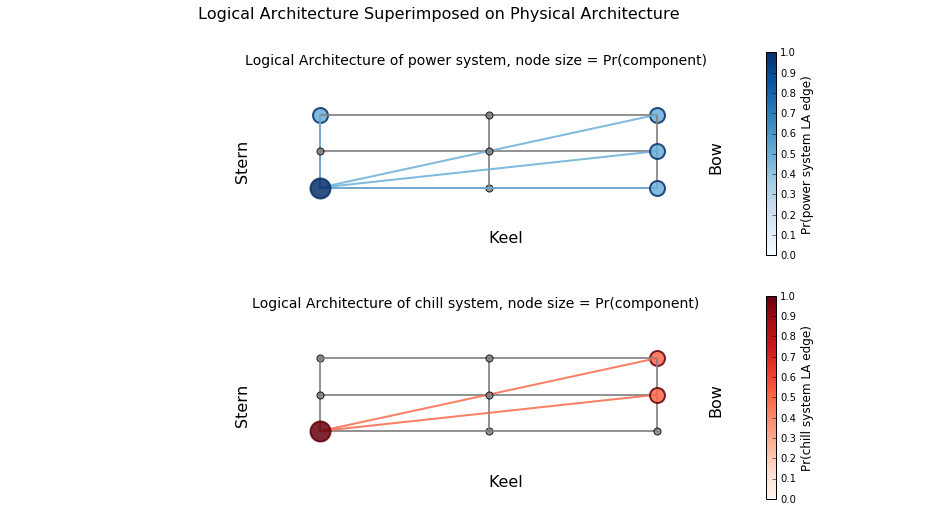

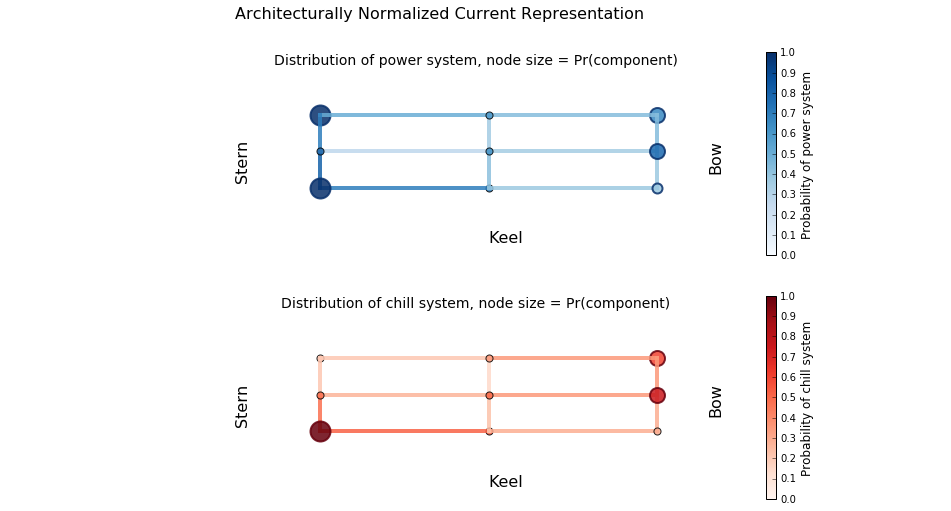

In [142]:
g,la, g_i, ir_la=basic_arch()
print 'results'
for c,d in ir_la['components'].iteritems():
    print c,d

In [375]:
score=(0,2)
threshold=(1,2)
below=all(x =< y for x, y in zip(score,threshold))
print below

False


In [381]:
x=1.0
y=(0,2)
print isinstance(x,float)
print isinstance(y,tuple)

True
True
